# **Task 5**

## **Import Libraries**

In [ ]:
import kagglehub
import os
import pandas as pd
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation ,NMF
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [ ]:
stop_words = set(stopwords.words("english"))

## **Load data and Exploration**

In [ ]:
# Download latest version
path = kagglehub.dataset_download("gpreda/bbc-news")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'bbc-news' dataset.
Path to dataset files: /kaggle/input/bbc-news


In [ ]:
# Load BBC news dataset (articles + categories)
file_path = os.path.join(path, "bbc_news.csv")
df = pd.read_csv(file_path)

In [ ]:
df.head()

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...


In [ ]:
display(df.columns)

Index(['title', 'pubDate', 'guid', 'link', 'description'], dtype='object')

## **Preprocessing**

In [ ]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Cleaning
    text = re.sub(r'http\S+\s*', ' ', text)       # remove URLs
    text = re.sub(r'RT|cc', ' ', text)            # remove RT and cc
    text = re.sub(r'#\S+', '', text)              # remove hashtags
    text = re.sub(r'@\S+', ' ', text)             # remove mentions
    text = re.sub(r'[^\w\s]', '', text)           # remove punctuation
    text = re.sub(r'\d+', '', text)               # remove digits
    text = re.sub(r'\s+', ' ', text).strip()      # remove extra spaces
    text = re.sub(r'\n', ' ', text)               # remove newlines
    text = re.sub(r'\r', ' ', text)               # remove carriage returns
    text = re.sub(r'[^\x00-\x7f]', ' ', text)     # remove non-ASCII
    text = re.sub(r'\&\#[0-9]+\;', ' ', text)     # remove HTML entities
    text = re.sub(r'<[^>]*>', '', text)           # remove HTML tags
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)  # remove emojis
    # Tokenization
    tokens = word_tokenize(text)
    # Stopword removal
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Stemming
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]

    return ' '.join(tokens)


In [ ]:
df["clean_text"] = df["description"].apply(preprocess_text)

In [ ]:
print("\nCleaned sample:")
df["clean_text"].head()


Cleaned sample:


,clean_text
0,ukrainian presid say countri forgiv forget mur...
1,jeremi bowen frontlin irpin resid came russian...
2,one world biggest fertilis firm say conflict c...
3,parent manchest arena bomb youngest victim spe...
4,consum feel impact higher energi cost fuel pri...


## **Vectorization**

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
doc_term_matrix = vectorizer.fit_transform(df["clean_text"])

In [ ]:
print("Shape of Document-Term Matrix:", doc_term_matrix.shape)

Shape of Document-Term Matrix: (42115, 13792)


## **Apply LDA**

In [ ]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

## **Display Topics**

In [ ]:
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[f"Topic {idx+1}"] = top_features
    return topics

In [ ]:
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda_model, feature_names, n_top_words)


In [ ]:
print("\n--- Dominant Topics (Top Words) ---")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")


--- Dominant Topics (Top Words) ---
Topic 1: say, year, bbc, star, new, uk, woman, time, age, open
Topic 2: say, polic, peopl, ukrain, attack, kill, russia, russian, bbc, war
Topic 3: say, uk, govern, new, minist, bbc, year, elect, parti, plan
Topic 4: leagu, manchest, unit, citi, say, premier, liverpool, manag, club, win
Topic 5: england, world, win, cup, final, day, watch, women, wale, game


# **Bouns Task 5**

In [ ]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

count_data = count_vectorizer.fit_transform(df["clean_text"])
tfidf_data = tfidf_vectorizer.fit_transform(df["clean_text"])

## **Train Models**

In [ ]:
n_topics = 5

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(count_data)

nmf = NMF(n_components=n_topics, random_state=42, init="nndsvd")
nmf.fit(tfidf_data)

NMF(init='nndsvd', n_components=5, random_state=42)

## **Display Top Words**

In [ ]:
def get_top_words(model, feature_names, n_top_words):
    topics = {}
    for idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {idx+1}"] = top_features
    return topics

lda_topics = get_top_words(lda, count_vectorizer.get_feature_names_out(), 10)
nmf_topics = get_top_words(nmf, tfidf_vectorizer.get_feature_names_out(), 10)

In [ ]:
print("\n--- LDA Topics ---")
for t, words in lda_topics.items():
    print(f"{t}: {', '.join(words)}")



--- LDA Topics ---
Topic 1: say, year, bbc, star, new, uk, woman, time, age, open
Topic 2: say, polic, peopl, ukrain, attack, kill, russia, russian, bbc, war
Topic 3: say, uk, govern, new, minist, bbc, year, elect, parti, plan
Topic 4: leagu, manchest, unit, citi, say, premier, liverpool, manag, club, win
Topic 5: england, world, win, cup, final, day, watch, women, wale, game


In [ ]:
print("\n--- NMF Topics ---")
for t, words in nmf_topics.items():
    print(f"{t}: {', '.join(words)}")


--- NMF Topics ---
Topic 1: uk, bbc, year, peopl, new, elect, govern, minist, rise, prime
Topic 2: world, england, cup, win, final, women, watch, wale, beat, euro
Topic 3: day, seven, past, pay, attent, close, select, imag, strike, taken
Topic 4: say, polic, attack, ukrain, woman, man, offic, russia, yearold, peopl
Topic 5: leagu, manchest, citi, premier, unit, champion, win, liverpool, arsen, season


## **Visualization**

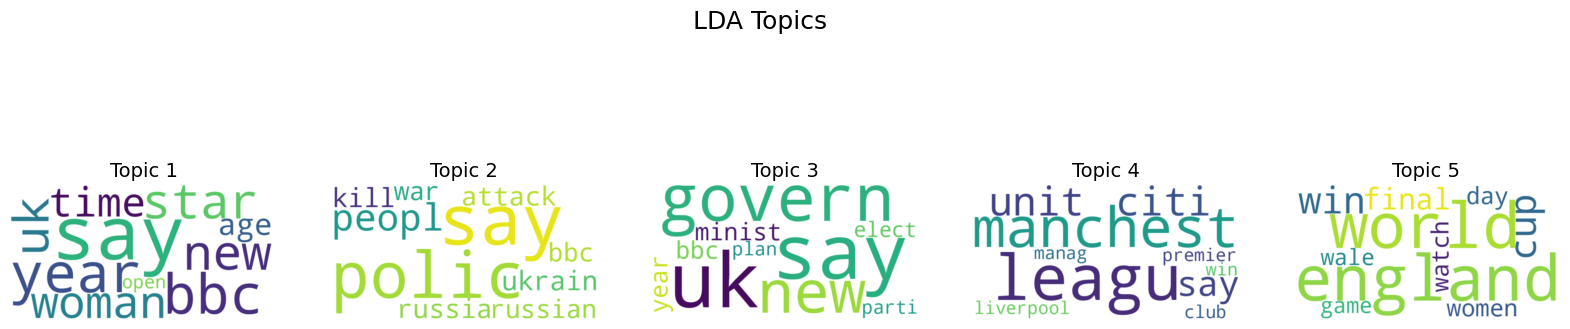

In [ ]:
# Visualize LDA topics with word clouds
fig_lda, axes_lda = plt.subplots(1, len(lda_topics), figsize=(20, 5))
fig_lda.suptitle("LDA Topics", fontsize=18)
for ax, (topic, words) in zip(axes_lda, lda_topics.items()):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(topic, fontsize=14)
    ax.axis("off")
plt.show()


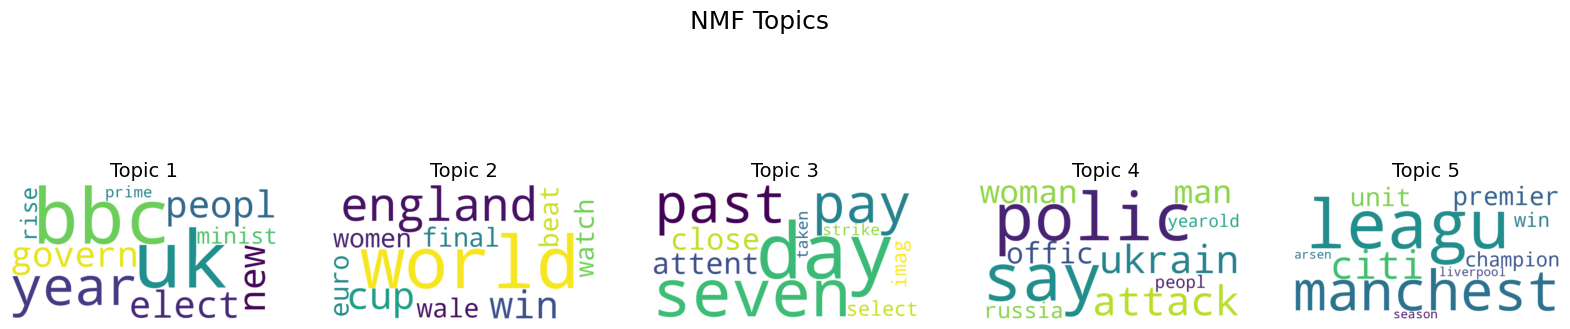

In [ ]:
# Visualize NMF topics with word clouds
fig_nmf, axes_nmf = plt.subplots(1, len(nmf_topics), figsize=(20, 5))
fig_nmf.suptitle("NMF Topics", fontsize=18)
for ax, (topic, words) in zip(axes_nmf, nmf_topics.items()):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(words))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title(topic, fontsize=14)
    ax.axis("off")
plt.show()